<a href="https://colab.research.google.com/github/vaguiar/CodingSamples/blob/master/hw2_q2_2_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip  install tf-nightly-2.0-preview

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import os

# The code in this notebook should work identically in TF v1 and v2
import tensorflow as tf
import zipfile

import tensorflow.keras.applications as applications
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-dev20190302


### Reading Data

In [24]:
# Importing Data from drive and then unzipping
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DnkaKuFygYNyxrXxhsETZ4WdGAWtmhpe' -O '/tmp/columbia.zip'

--2019-03-03 00:02:38--  https://docs.google.com/uc?export=download&id=1DnkaKuFygYNyxrXxhsETZ4WdGAWtmhpe
Resolving docs.google.com (docs.google.com)... 74.125.23.100, 74.125.23.113, 74.125.23.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.23.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&continue=https://docs.google.com/uc?export%3Ddownload%26id%3D1DnkaKuFygYNyxrXxhsETZ4WdGAWtmhpe&followup=https://docs.google.com/uc?export%3Ddownload%26id%3D1DnkaKuFygYNyxrXxhsETZ4WdGAWtmhpe&ltmpl=homepage [following]
--2019-03-03 00:02:38--  https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&continue=https://docs.google.com/uc?export%3Ddownload%26id%3D1DnkaKuFygYNyxrXxhsETZ4WdGAWtmhpe&followup=https://docs.google.com/uc?export%3Ddownload%26id%3D1DnkaKuFygYNyxrXxhsETZ4WdGAWtmhpe&ltmpl=homepage
Resolving accounts.google.com (accounts.google.com)... 74.1

In [0]:
!unzip '/tmp/columbia.zip' -d /tmp

base_dir = '/tmp/images/'

#### Another option - Google drive mounted

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

# base_dir = '/content/drive/My Drive/DeepLearning_Spring_2019/HW2/hw2_data/images/'

In [0]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validate')

train_lion_dir = os.path.join(train_dir, 'lion')
train_thinker_dir = os.path.join(train_dir, 'thinker')
train_eye_dir = os.path.join(train_dir, 'eye')
train_blob_dir = os.path.join(train_dir, 'blob')

validation_lion_dir = os.path.join(validation_dir, 'lion')
validation_thinker_dir = os.path.join(validation_dir, 'thinker')
validation_eye_dir = os.path.join(validation_dir, 'eye')
validation_blob_dir = os.path.join(validation_dir, 'blob')

In [36]:
t_set1 = len(os.listdir(train_lion_dir))
t_set2 = len(os.listdir(train_thinker_dir))
t_set3 = len(os.listdir(train_eye_dir))
t_set4 = len(os.listdir(train_blob_dir))
                
v_set1 = len(os.listdir(validation_lion_dir))
v_set2 = len(os.listdir(validation_thinker_dir))
v_set3 = len(os.listdir(validation_eye_dir))
v_set4 = len(os.listdir(validation_blob_dir))

total_train = t_set1 + t_set2 + t_set3 + t_set4
total_val = v_set1 + v_set2 + v_set3 + v_set4
    
print("Total training images:", total_train)
print("Total validation images:", total_val)

Total training images: 200
Total validation images: 125


### Helper Functions


In [0]:
# This function will plot images in a grid with 1 row and 5 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [0]:
# Create a model with the convolution base

def getModel(conv_base):
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(NUM_OF_CLASSES, activation='softmax'))
  
  return model

In [0]:
# Compile and build

def trainModel(model, total_train, total_val, 
               train_data_gen, val_data_gen, EPOCHS):
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])

  history = model.fit_generator(
        train_data_gen,
        steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
        epochs=EPOCHS,
        validation_data=val_data_gen,
        validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
        verbose=2)
  
  return history

In [0]:
# Print Train/Validate accuracy and loss

def plotTrainVal(history, EPOCHS):

  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(1, EPOCHS+1)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

### Global Constants

In [0]:
# Images will be resized to(TARGET_SHAPE, TARGET_SHAPE) as they're read off disk.
TARGET_SHAPE = 150 
BATCH_SIZE = 32

CLASS_MODE = 'categorical'
NUM_OF_CLASSES = 4

### Image Generators w/ Data Augmentation


In [42]:
# Re-read our data with Data Augmentation techniques

image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode=CLASS_MODE)

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode=CLASS_MODE)

Found 200 images belonging to 4 classes.
Found 125 images belonging to 4 classes.


### Plot Sample Data

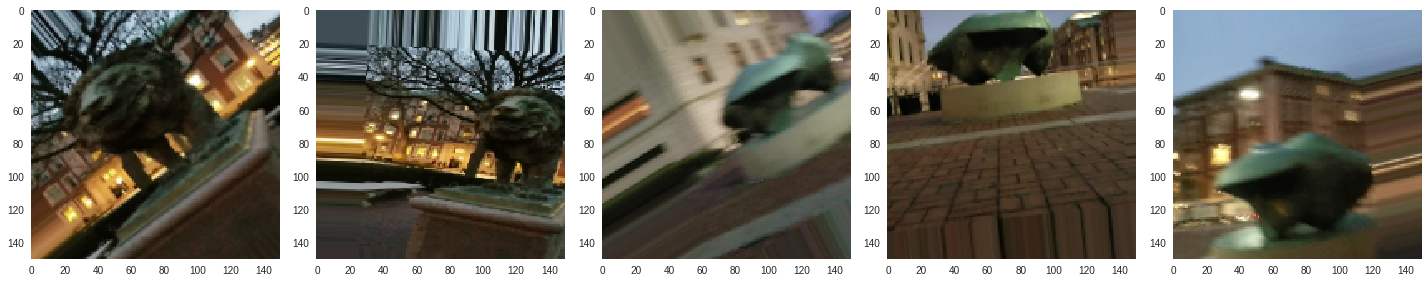

In [43]:
sample_training_images, sample_training_labels = next(train_data_gen)

plotImages(sample_training_images[:5])

### Using VGG16 as our Model

In [0]:
vgg16 = applications.VGG16(weights='imagenet',include_top=False, input_shape=(150, 150, 3))

conv_base = vgg16
conv_base.trainable = False

model = getModel(conv_base)

EPOCHS = 50

In [0]:
%%time

history = trainModel(model, total_train, total_val, 
           train_data_gen, val_data_gen, EPOCHS)

Epoch 1/50
7/7 - 88s - loss: 3.4956 - acc: 0.3300 - val_loss: 1.4868 - val_acc: 0.5600
Epoch 2/50
7/7 - 81s - loss: 0.6302 - acc: 0.7550 - val_loss: 0.4917 - val_acc: 0.7920
Epoch 3/50


In [0]:
plotTrainVal(history, EPOCHS)

### Transfer Learning with ResNET50

In [0]:
resNet50  = applications.ResNet50(weights='imagenet',include_top=False, 
                                  input_shape=(150, 150, 3))

conv_base = resNet50
conv_base.trainable = False
model = getModel(conv_base)


EPOCHS = 50

In [0]:
%%time

history = trainModel(model, total_train, total_val, 
           train_data_gen, val_data_gen, EPOCHS)

In [0]:
plotTrainVal(history, EPOCHS)

### Transfer Learning with InceptionV3

In [0]:
inceptionV3  = applications.InceptionV3(weights='imagenet',include_top=False, 
                                        input_shape=(150, 150, 3))

conv_base = inceptionV3
conv_base.trainable = False
model = getModel(conv_base)


EPOCHS = 50

In [0]:
%%time

history = trainModel(model, total_train, total_val, 
           train_data_gen, val_data_gen, EPOCHS)

In [0]:
plotTrainVal(history, EPOCHS)

## Q2.3 - Training with the least number of parameters

In [0]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(NUM_OF_CLASSES, activation='softmax'))